In [1]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from tqdm import tqdm
from utils import *
import segmentation_models_pytorch as smp
from PIL import Image

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
class segmentations(Dataset):
    def __init__(self, root, transformations = None):
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path_jpg = glob(f"{root}/Image/*.jpg")
        self.im_mask_png = glob(f"{root}/Mask/*.png")        
 
        self.total_ims = len(self.im_path_jpg)
        self.total_gts = len(self.im_mask_png)
        
        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')  
        
        
    def __len__(self):
        return len(self.im_path_jpg)
    
    
    def __getitem__(self, idx):
        
        try: im = cv2.cvtColor(cv2.imread(self.im_path_jpg[idx]), cv2.COLOR_BGR2RGB)
        except: print(self.im_path_jpg[idx])
        gt = np.array(Image.open(self.im_mask_png[idx]))
        
        if self.transformations is not None:
            transformed = self.transformations(image = im, mask = gt)
            im, gt = transformed['image'], transformed['mask']
        
        return self.tensorize(im), torch.tensor(gt > 128).long()


def get_transformation(size):
        
    tfs = A.Compose([A.Resize(size, size)])
    return tfs

tfs = get_transformation(224)[0]     
ds = segmentations(root='flood', transformations=tfs)
ds[0][1].shape
print(type(ds[0][0]))

There are 290 images and 290 masks in the dataset
<class 'torch.Tensor'>


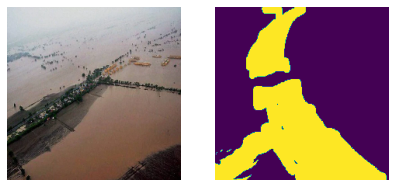

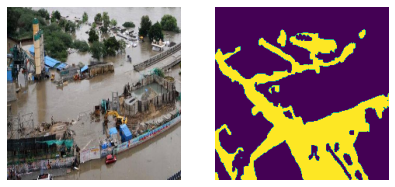

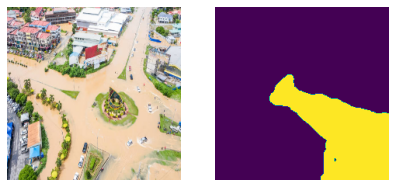

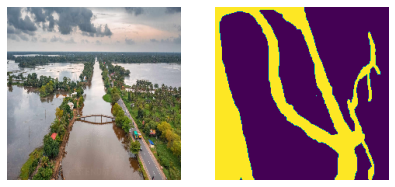

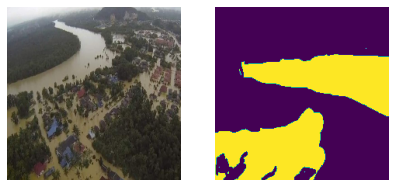

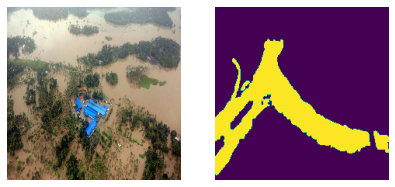

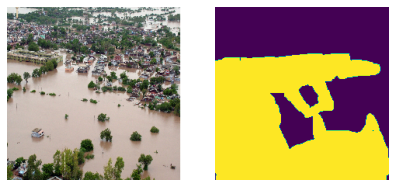

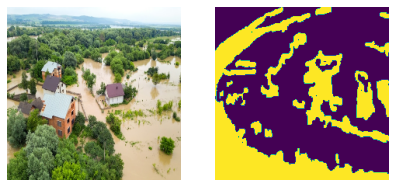

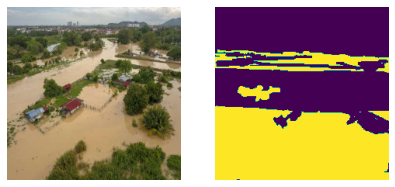

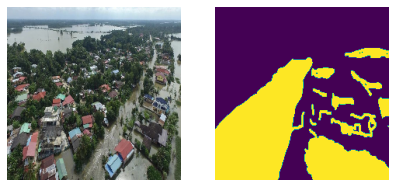

<Figure size 1296x1296 with 0 Axes>

In [13]:
def showing(ds, img_num=10, row=2):
    for idx, (im, gt) in enumerate(ds):
        count = 1
        plt.figure(figsize=(18,18))
        if idx == 10: break
        im = (im * 255).detach().cpu().permute(1,2,0).numpy().astype('uint8')# integer 8
        gt = (gt * 255).detach().cpu().numpy().astype('uint8')
        plt.subplot(row, img_num // row, count)
        plt.imshow(im)
        plt.axis('off')
        count += 1
        plt.subplot(row, img_num // row, count)
        plt.imshow(gt)
        plt.axis('off')
        count += 1
        plt.show()
        
showing(ds, 10, 2)    

In [14]:
def get_dl(root, transformations, bs, split = [0.7, 0.15, 0.15]):
    
    assert sum(split) == 1
    # Get dataset
    ds = segmentations(root = root, transformations = tfs)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    
    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = bs, shuffle = False)
    
    return tr_dl, val_dl, test_dl 
    
tr_dl, val_dl, test_dl = get_dl(root = "flood", bs = 64, transformations = tfs) 


There are 290 images and 290 masks in the dataset
There are 203 images in the trainset
There are 43 images in the validation set
There are 44 images in the test set


In [15]:
class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, n_cls = 2):
        
        
        self.pred_ = pred # to compute loss value
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1)), gt 
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim = 1), gt 
        self.loss_fn, self.eps, self.n_cls = loss_fn, eps, n_cls
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) # (3, 224, 224) -> (3 * 224 * 224)

    def PA(self):
        
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.gt).int()
            
        return float(match.sum()) / float(match.numel()) # numel() is a number of elements in match
    
    def mIoU(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            
            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt   == c
                
                # If there is no background class
                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                
                else:
                    
                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    
                    iou = (intersection) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, self.gt)

In [16]:
def train(model, tr_dl, val_dl, loss_fn, opt, epochs, device, patience):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss = torch.tensor(float("inf"))
    not_improved = 0
    #os.makedirs("saved_models", exist_ok = True)
    
    model.to(device)
    for epoch in range(1, epochs + 1):  
        
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        
        print(f"{epoch}-epoch train is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            im, gt = batch
            
            
            im, gt = im.to(device), gt.to(device)
            
            pred = model(im)
            
            met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)
            
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_
            
            loss_.backward() 
            opt.step() 
            opt.zero_grad()
            
        print(f"{epoch}-epoch train is finished!")
        print(f"{epoch}-epoch validation is started...")
        
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
            
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)

                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                val_loss_ += met.loss().item()
            
        print(f"{epoch}-epoch validation is finished!")
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} Train Process Results: \n")
        print(f"Train loss          -> {tr_loss_:.3f}")
        print(f"Train PA            -> {tr_pa_:.3f}")
        print(f"Train mIoU          -> {tr_iou_:.3f}")
        print(f"Validation loss     -> {val_loss_:.3f}")
        print(f"Validation PA       -> {val_pa_:.3f}")
        print(f"Validation mIoU     -> {val_iou_:.3f}")
        
        tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_)
        val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_)
        
        if best_loss < val_loss_:
            print(f"Loss value did not decrease")
            not_improved += 1
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
        
        else:
            print(f"Loss decreased from {best_loss} to {val_loss_}")
            best_loss = val_loss_
            #torch.save(model, f"saved_models/{save_prefix}_best_model.pt")
            
    return {"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
            "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}



In [17]:
model = smp.Unet(encoder_name = 'resnet18',
               encoder_weights = 'imagenet',
               in_channels = 3,
               classes = 2,
               encoder_depth = 5,
               decoder_channels = [256,128,64,32,16])

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

In [19]:
his = train(model = model, tr_dl = tr_dl,
            val_dl = val_dl, loss_fn = loss_fn,
            opt = opt, epochs = 10, device = "cuda",
            patience = 3)


1-epoch train is started...


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


1-epoch train is finished!
1-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


1-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 Train Process Results: 

Train loss          -> 0.798
Train PA            -> 0.502
Train mIoU          -> 0.335
Validation loss     -> 1.273
Validation PA       -> 0.586
Validation mIoU     -> 0.319
Loss decreased from inf to 1.272672414779663
2-epoch train is started...


100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


2-epoch train is finished!
2-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


2-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 Train Process Results: 

Train loss          -> 0.690
Train PA            -> 0.570
Train mIoU          -> 0.393
Validation loss     -> 0.919
Validation PA       -> 0.560
Validation mIoU     -> 0.348
Loss decreased from 1.272672414779663 to 0.9187451601028442
3-epoch train is started...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


3-epoch train is finished!
3-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


3-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 Train Process Results: 

Train loss          -> 0.637
Train PA            -> 0.636
Train mIoU          -> 0.449
Validation loss     -> 0.721
Validation PA       -> 0.548
Validation mIoU     -> 0.369
Loss decreased from 0.9187451601028442 to 0.721470296382904
4-epoch train is started...


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


4-epoch train is finished!
4-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


4-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 Train Process Results: 

Train loss          -> 0.579
Train PA            -> 0.696
Train mIoU          -> 0.513
Validation loss     -> 0.713
Validation PA       -> 0.538
Validation mIoU     -> 0.364
Loss decreased from 0.721470296382904 to 0.7125937342643738
5-epoch train is started...


100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


5-epoch train is finished!
5-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


5-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 Train Process Results: 

Train loss          -> 0.509
Train PA            -> 0.757
Train mIoU          -> 0.588
Validation loss     -> 0.820
Validation PA       -> 0.518
Validation mIoU     -> 0.349
Loss value did not decrease
6-epoch train is started...


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


6-epoch train is finished!
6-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


6-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 Train Process Results: 

Train loss          -> 0.487
Train PA            -> 0.770
Train mIoU          -> 0.609
Validation loss     -> 0.803
Validation PA       -> 0.550
Validation mIoU     -> 0.360
Loss value did not decrease
7-epoch train is started...


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


7-epoch train is finished!
7-epoch validation is started...


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

7-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 Train Process Results: 

Train loss          -> 0.470
Train PA            -> 0.779
Train mIoU          -> 0.626
Validation loss     -> 0.925
Validation PA       -> 0.539
Validation mIoU     -> 0.368
Loss value did not decrease
Stop training since loss value did not decrease for 3 epochs.
